#### Setup

In [71]:
import torch

import pandas as pd
import pingouin as pg

from pathlib import Path
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13

import plotly.graph_objects as go
from IPython import display

ANOVA

In [72]:
def do_anova(table, threshold=0.01, print_now=False, index=None, columns=None):
    df = pd.DataFrame(table, index=index, columns=columns)
    result = pg.rm_anova(df).loc[0]
    f_value = result['F']
    p_value = result['p-unc']
    significance = 'significant' if p_value < threshold else 'not significant'
    
    if print_now:
        display.display(display.Latex(f'$p$-value={p_value:.4E}'))
        # print(f'{p_value=:.4E}')
        display.display(display.Latex(f'which is {significance} with $p < {threshold}$.'))
        # print(f'Which is {significance} with p < {threshold}.')
        display.display(df)
    else:
        return df, f_value, p_value, significance


# test_table = torch.randn(4, 3)
# test_index = list('abcd')
# test_columns = list('ABC')
# do_anova(test_table, index=test_index, columns=test_columns, print_now=True)

Paths

In [99]:
archs = [
    'resnet18', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d',
    'vit', 'swin', 'toy',
]
arch_names = [
    'ResNet18', 'VGG19', 'MobileNet_v2', 'ResNeXt29_2x64d',
    'ViT', 'Swin', 'MNIST_toy',
]

algs = [
    'rgf_sgd', 'rgf_adam', 
    'spsa_sgd', 'spsa_nag', 'spsa_adam',
]
alg_names = [
    'RGF', 'RGF_Adam', 
    'SPSA', 'SPSA-GC', 'SPSA-AM',
]

datasets = [
    'cifar10', 'cifar100', 'mnist',
]
dataset_names = [
    'CIFAR-10', 'CIFAR-100', 'MNIST',
]

logdir = Path('./log')

#### Evaluation

##### Feasibility across Victims

In [74]:
here_archs = archs[:-1]
arch_dirs = [logdir.joinpath(f'cifar10_{arch}_1.0', '_baselines') for arch in here_archs]
arch_dirs[-2] = logdir.joinpath(f'cifar10_vit_1.0', 'alg', 'spsa_adam')  # ViT

table = []
for arch_n, arch_d in zip(here_archs, arch_dirs):
    exp_dirs = sorted(glob(arch_d.joinpath('*').__str__()))
    exp_dirs = map(Path, exp_dirs)
    
    fr_list = torch.tensor([torch.load(exp_d.joinpath('ckpt.pth'))['fr'] 
                            for exp_d in exp_dirs])
    table.append(fr_list)
table = torch.stack(table, dim=1)

do_anova(table=table, print_now=True,
         index=[f'{i:02d}' for i in range(table.size(0))], 
         columns=arch_names[:-1])

print(table.mean(dim=0))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

,ResNet18,VGG19,MobileNet_v2,ResNeXt29_2x64d,ViT,Swin
00,85.260002,60.680000,87.339996,88.669998,56.689999,65.230003
01,85.739998,64.599998,88.400002,88.440002,57.779999,64.970001
02,85.750000,66.970001,87.699997,88.919998,57.459999,66.309998
03,85.870003,66.470001,88.099998,88.650002,57.520000,66.559998
04,85.650002,68.120003,88.809998,88.849998,58.349998,65.830002
05,85.750000,62.410000,87.769997,88.860001,57.200001,66.449997
06,85.620003,62.049999,88.419998,88.800003,57.980000,65.680000
07,85.900002,60.880001,88.500000,88.559998,56.830002,66.790001
08,85.919998,66.940002,88.180000,88.190002,58.669998,64.959999
09,85.919998,64.669998,87.980003,88.589996,58.060001,65.680000


tensor([85.8760, 63.5320, 88.0580, 88.5945, 57.6780, 65.7040])


##### Opitmization Algorithms

In [111]:
alg_dirs = [logdir.joinpath(f'cifar10_vit_1.0', 'alg', alg) for alg in algs]

table = []
for alg_n, alg_d in zip(alg_names, alg_dirs):
    exp_dirs = sorted(glob(alg_d.joinpath('*').__str__()))
    exp_dirs = map(Path, exp_dirs)
    
    fr_list = torch.tensor([torch.load(exp_d.joinpath('ckpt.pth'))['fr'] 
                            for exp_d in exp_dirs])
    table.append(fr_list)
num_exps = min(len(fr_list) for fr_list in table)
table = [fr_list[:num_exps] for fr_list in table]
table = torch.stack(table, dim=1)

do_anova(table=table, print_now=True,
         index=[f'{i:02d}' for i in range(table.size(0))], 
         columns=alg_names)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

,RGF,RGF_Adam,SPSA,SPSA-GC,SPSA-AM
00,45.180000,40.740002,60.419998,50.700001,56.689999
01,43.560001,40.630001,43.810001,50.009998,57.779999
02,43.770000,42.360001,60.939999,49.820000,57.459999
03,47.900002,41.529999,58.650002,49.790001,57.520000
04,46.160000,40.270000,62.230000,50.009998,58.349998
05,42.389999,41.040001,60.360001,49.930000,57.200001
06,43.860001,39.310001,60.619999,50.810001,57.980000
07,48.709999,41.869999,60.799999,49.169998,56.830002
08,42.240002,39.549999,61.720001,50.020000,58.669998
09,44.880001,40.070000,60.299999,50.490002,58.060001


/tmp/ipykernel_56651/2596340018.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


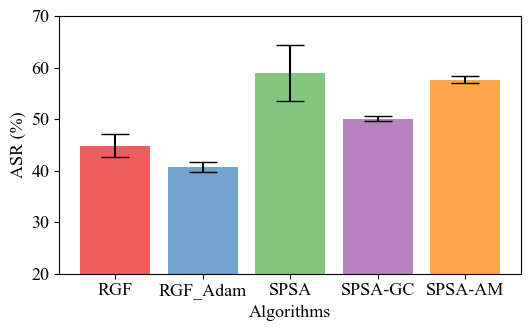

In [114]:

std, mean = torch.std_mean(table, dim=0)

plt.figure(figsize=(5.5, 3.5))
plt.bar(range(5), mean, yerr=std, capsize=10, color=cm.get_cmap('Set1')(range(5)), alpha=0.7)
plt.xticks(range(5), alg_names)
plt.xlabel('Algorithms')
plt.ylabel('ASR (%)')
plt.ylim(20, 70)
plt.tight_layout()

plt.savefig('./vis/significance-algs.pdf')
plt.savefig('./vis/significance-algs.png')
plt.show()

##### Significance of Datasets

In [115]:
dataset_dirs = [
    logdir.joinpath(dset, '_baselines')
    for dset in ['cifar10_resnet18_1.0', 'cifar100_resnet18_1.0', 'mnist_toy_1.0']
]

''' If consider MNIST with budget=75.57 '''
dataset_dirs.append(dataset_dirs[-1].parent.joinpath('_baselines_75.57'))
dnames = dataset_names + ['MNIST_75.57']

table = []
for dset_n, dset_d in zip(dnames, dataset_dirs):
    exp_dirs = sorted(glob(dset_d.joinpath('*').__str__()))
    exp_dirs = map(Path, exp_dirs)
    
    fr_list = torch.tensor([torch.load(exp_d.joinpath('ckpt.pth'))['fr'] 
                            for exp_d in exp_dirs])
    table.append(fr_list)
    
''' Fill NaN '''
num_exps = max(len(fr_list) for fr_list in table)
for i in range(len(table)):
    length = len(table[i])
    if length < num_exps:
        table[i] = torch.cat([table[i], torch.zeros(num_exps - length) + torch.nan], dim=0)

# ''' Drop rest '''
# num_exps = min(len(fr_list) for fr_list in table)
# table = [col[:num_exps] for col in table]

table = torch.stack(table, dim=1)

do_anova(table=table[:, 0:2], print_now=True,
         index=[f'{i:02d}' for i in range(table.size(0))], 
         columns=dnames[0:2])  # not significant (good)

# do_anova(table=table[:, 2:4], print_now=True,
#          index=[f'{i:02d}' for i in range(table.size(0))], 
#          columns=dnames[2:4])  # not significant (good)

# do_anova(table=table[:, 0:3], print_now=True,
#          index=[f'{i:02d}' for i in range(table.size(0))], 
#          columns=dnames[0:3])  # not significant (good)

# do_anova(table=table, print_now=True,
#          index=[f'{i:02d}' for i in range(table.size(0))], 
#          columns=dnames)  # significant

# do_anova(table=table.T, print_now=True,
#          index=dataset_names, 
#          columns=[f'{i:02d}' for i in range(table.size(0))])  # significant


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

,CIFAR-10,CIFAR-100
00,85.260002,84.410004
01,85.739998,88.459999
02,85.750000,85.300003
03,85.870003,88.709999
04,85.650002,85.559998
05,85.750000,84.849998
06,85.620003,88.949997
07,85.900002,88.269997
08,85.919998,86.160004
09,85.919998,85.930000


In [107]:
print('CIFAR10 - CIFAR100')
display.display(pg.ttest(*table.T[0:2]))
print()

print('CIFAR100 - MNIST')
display.display(pg.ttest(*table.T[1:3]))

CIFAR10 - CIFAR100


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.382422,38,two-sided,0.022307,"[-1.56, -0.13]",0.753388,2.708,0.641308



CIFAR100 - MNIST


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.107632,38,two-sided,0.000205,"[2.18, 6.42]",1.298947,117.302,0.979415


/tmp/ipykernel_56651/3200222100.py:10: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


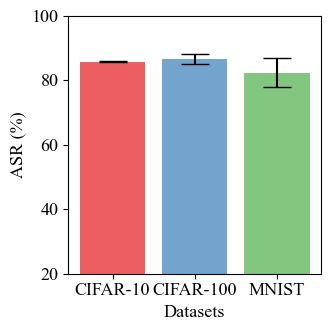

In [117]:
subtable = table[:, :3]
std, mean = torch.std_mean(subtable, dim=0)

plt.figure(figsize=(3.5, 3.5))
plt.bar(range(3), mean, yerr=std, capsize=10, color=cm.get_cmap('Set1')(range(3)), alpha=0.7)
plt.xticks(range(3), dataset_names)
plt.xlabel('Datasets')
plt.ylabel('ASR (%)')
plt.ylim([20, 100])
plt.tight_layout()

plt.savefig('./vis/significance-dsets.pdf')
plt.savefig('./vis/significance-dsets.png')
plt.show()

# Test

In [80]:
import torch
from pathlib import Path

# TODO spsa_cifar10_budget.sh 다 잘 됐는지 확인
victims = ['resnet18', 'resnet20', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d']
budgets = ['07.0', '10.0', '13.0']

logdir = Path('./log/')
for net in victims:
    expdir = logdir.joinpath(f'cifar10_{net}_1.0')
    for budget in budgets:
        ckpt_filename = expdir.joinpath('spsa_budget', budget, 'ckpt.pth')
        ckpt = torch.load(ckpt_filename)
        print(net, budget, ckpt['fr'])

resnet18 07.0 82.27
resnet18 10.0 86.96
resnet18 13.0 88.43
resnet20 07.0 72.82
resnet20 10.0 85.51
resnet20 13.0 87.81
vgg19 07.0 38.63
vgg19 10.0 68.94
vgg19 13.0 84.77
mobilenet_v2 07.0 84.95
mobilenet_v2 10.0 88.49
mobilenet_v2 13.0 89.6
resnext29_2x64d 07.0 86.58
resnext29_2x64d 10.0 89.03
resnext29_2x64d 13.0 90.87


In [81]:
import torch
from pathlib import Path

# TODO spsa_targeted.sh 얼마나 됐는지 확인
victims = ['resnet18', 'resnet20', 'vgg19', 'mobilenet_v2', 'resnext29_2x64d']

logdir = Path('./log/')
out_file = open('temp/out.txt', 'w')

for net in victims:
    expdir = logdir.joinpath(f'cifar10_{net}_1.0')
    for target in range(10):
        tardir = expdir.joinpath('spsa_targeted', f'{target:02d}')
        if not tardir.exists():
            print(net, target, 'None', file=out_file, flush=True)
            continue
        
        ckpt_filename = tardir.joinpath('ckpt.pth')
        ckpt = torch.load(ckpt_filename)
        
        log_filename = tardir.joinpath('train.log')
        with open(log_filename, 'r') as log_file:
            line = log_file.readlines()[-12].strip()
        
        print(net, target, ckpt['fr'], line, file=out_file, flush=True)

In [82]:
here_archs = archs[:-1]
arch_dirs = [logdir.joinpath(f'cifar10_{arch}_1.0', '_baselines') for arch in here_archs]
arch_dirs[-2] = logdir.joinpath(f'cifar10_vit_1.0', 'alg', 'spsa_adam')  # ViT

table = []
uaps = []
times = []
for arch_n, arch_d in zip(here_archs, arch_dirs):
    exp_dirs = sorted(glob(arch_d.joinpath('*').__str__()))
    exp_dirs = map(Path, exp_dirs)
    
    ckpts = [torch.load(exp_d.joinpath('ckpt.pth')) for exp_d in exp_dirs]
    print(ckpts[0]['args'])
    fr_list = torch.tensor([ckpt['fr'] for ckpt in ckpts], dtype=torch.double)
    uap_list = torch.cat([ckpt['uap'] for ckpt in ckpts], dim=0)
    time_list = torch.tensor([ckpt['time'] for ckpt in ckpts], dtype=torch.double)
    
    table.append(fr_list)
    uaps.append(uap_list)
    times.append(time_list)
table = torch.stack(table, dim=1)
uaps = torch.stack(uaps, dim=1)
times = torch.stack(times, dim=1)

# Evaluation
mean_fr = table.mean(dim=0).round(decimals=2)
print(f'{mean_fr=}')

norm = uaps.norm(p=2, dim=(2, 3, 4)) * 255.0
mean_norm = norm.mean(dim=0).round(decimals=2)
print(f'{mean_norm=}')

mean_time = times.mean(dim=0).round(decimals=2)
print(f'{mean_time=}')

{'device': 'cuda:0', 'seed': None, 'deterministic': True, 'epochs': 800, 'beta': 0.01, 'learning_rate': 0.001, 'algorithm': 'rgf', 'optimizer': {'name': 'Adam', 'kwargs': {'betas': [0.5, 0.999]}}, 'beta_scheduler': {'name': 'StepLR', 'kwargs': {'step_size': 100, 'gamma': 0.9}}, 'lr_scheduler': {'name': 'CosineAnnealingWarmRestarts', 'kwargs': {'eta_min': '${eval:${learning_rate} * 0.1}', 'T_0': '${epochs}', 'T_mult': 1}}, 'batch_size': 256, 'eval_batch_size': 512, 'images_per_class': -1, 'eval_images_per_class': -1, 'accumulation': 1, 'max_iters': -1, 'sliding_window_batch': False, 'augmentations': [], 'target': -1, 'budget': 10.0, 'regulation': 'clamp', 'eval_step_size': -1, 'loss_func': 'accuracy', 'use_logits': False, 'checkpoint': 'cifar10_resnet18_1.0', 'tag': '_baselines/00', 'config': ['cifar10-optim/adam'], 'benchmark': False}
{'device': 'cuda:3', 'seed': None, 'deterministic': True, 'epochs': 800, 'beta': 0.01, 'learning_rate': 0.001, 'algorithm': 'rgf', 'optimizer': {'name': 

In [83]:
import torch

ckpt = torch.load('./log/cifar10_vit_1.0/_baselines/00/ckpt.pth')
# ckpt = torch.load('./log/cifar10_resnet18_1.0/_baselines/05/ckpt.pth')
fr_list = torch.tensor(ckpt['fr_list'])

print(ckpt['args'])
print(ckpt['time'], 'seconds')

epochs = len(fr_list)
print(max(fr_list[:epochs//2]))

# idx = torch.searchsorted(fr_list, 50.0)
# print(idx)
# print(fr_list[idx])
# print(fr_list[600:idx+1])

print(fr_list[530])

{'device': 'cuda:6', 'seed': None, 'deterministic': True, 'epochs': 800, 'beta': 0.01, 'learning_rate': 0.001, 'algorithm': 'rgf', 'optimizer': {'name': 'Adam', 'kwargs': {'betas': [0.5, 0.999]}}, 'beta_scheduler': {'name': 'StepLR', 'kwargs': {'step_size': 100, 'gamma': 0.9}}, 'lr_scheduler': {'name': 'CosineAnnealingWarmRestarts', 'kwargs': {'eta_min': '${eval:${learning_rate} * 0.1}', 'T_0': '${epochs}', 'T_mult': 1}}, 'batch_size': 256, 'eval_batch_size': 512, 'images_per_class': -1, 'eval_images_per_class': -1, 'accumulation': 1, 'max_iters': -1, 'sliding_window_batch': False, 'augmentations': [], 'target': -1, 'budget': 10.0, 'regulation': 'clamp', 'eval_step_size': -1, 'loss_func': 'accuracy', 'use_logits': False, 'checkpoint': 'cifar10_vit_1.0', 'tag': 'alg/spsa_adam/00', 'config': ['cifar10-optim/adam'], 'benchmark': False}
9894.530625104904 seconds
tensor(34.1300)
tensor(44.9100)


In [84]:
arch = 'swin'
time = []
for i in range(20):
    ckpt = torch.load(f'./log/cifar10_{arch}_1.0/_baselines/{i:02d}/ckpt.pth')
    time.append(ckpt['time'])
    
print(sum(time) / len(time))

11009.547725808621
